![](https://images.unsplash.com/photo-1602084551218-a28205125639?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

<div class = 'alert alert-block alert-info'
     style = 'background-color:#4c1c84;
              color:#eeebf1;
              border-width:5px;
              border-color:#4c1c84;
              font-family:Comic Sans MS;
              border-radius: 50px 50px'>
    <p style = 'font-size:24px'>Exp 018</p>
    <a href = "#Config"
       style = "color:#eeebf1;
                font-size:14px">1.Config</a><br>
    <a href = "#Settings"
       style = "color:#eeebf1;
                font-size:14px">2.Settings</a><br>
    <a href = "#Data-Load"
       style = "color:#eeebf1;
                font-size:14px">3.Data Load</a><br>
    <a href = "#Pytorch-Settings"
       style = "color:#eeebf1;
                font-size:14px">4.Pytorch Settings</a><br>
    <a href = "#Training"
       style = "color:#eeebf1;
                font-size:14px">5.Training</a><br>
</div>

<p style = 'font-size:24px;
            color:#4c1c84'>
    実施したこと
</p>
    <li style = "color:#4c1c84;
                font-size:14px">過去コンペの予測ラベル</li>
    <li style = "color:#4c1c84;
                font-size:14px">TFIDF</li>
    <li style = "color:#4c1c84;
                font-size:14px">SVR</li>

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Config
</h1>
<br>

In [2]:
import sys
sys.path.append("../src/utils/iterative-stratification/")

In [3]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

2022-01-19 06:16:47.125225: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import torch

config = {
    "seed": 42,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 5,
    "epoch": 5,
    "max_length": 128,
    "environment": "AWS",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "018_exp",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 8,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": False,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 32,
        "shuffle": True,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": True,
    },

    "valid_loader": {
        "batch_size": 64,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 32,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "roberta-base",
        "output_dim": 1,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-4,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.MarginRankingLoss",
}

config = Box(config)
config.tokenizer = AutoTokenizer.from_pretrained(config.backbone.name)
pprint(config)

{'backbone': <Box: {'name': 'roberta-base', 'output_dim': 1}>,
 'entity': 'dataskywalker',
 'environment': 'AWS',
 'epoch': 5,
 'exp_name': '018_exp',
 'loss': 'nn.MarginRankingLoss',
 'margin': 0.5,
 'max_length': 128,
 'n_fold': 5,
 'optimizer': <Box: {'name': 'torch.optim.AdamW', 'params': {'lr': 0.0001}}>,
 'project': 'Jigsaw',
 'root': '/content/drive/MyDrive/kaggle/Jigsaw/raw',
 'scheduler': {'name': 'torch.optim.lr_scheduler.CosineAnnealingWarmRestarts',
               'params': <Box: {'T_0': 20, 'eta_min': 0}>},
 'seed': 42,
 'test_loader': {'batch_size': 32,
                 'drop_last': False,
                 'num_workers': 1,
                 'pin_memory': True,
                 'shuffle': False},
 'tokenizer': PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>',

In [5]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'AWS'.
INPUT_DIR is /mnt/work/data/kaggle/Jigsaw
MODEL_DIR is ../models/018_exp
OUTPUT_DIR is ../data/interim/018_exp
UTIL_DIR is /mnt/work/shimizu/kaggle/PetFinder/src/utils


In [6]:
# Seed固定
seed_everything(config.seed)

42

In [7]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

# Data Load

In [8]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv
/mnt/work/data/kaggle/Jigsaw/sample_submission.csv
/mnt/work/data/kaggle/Jigsaw/validation_data.csv


In [9]:
df = pd.read_csv(INPUT_DIR/"validation_data.csv")
df.head()

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


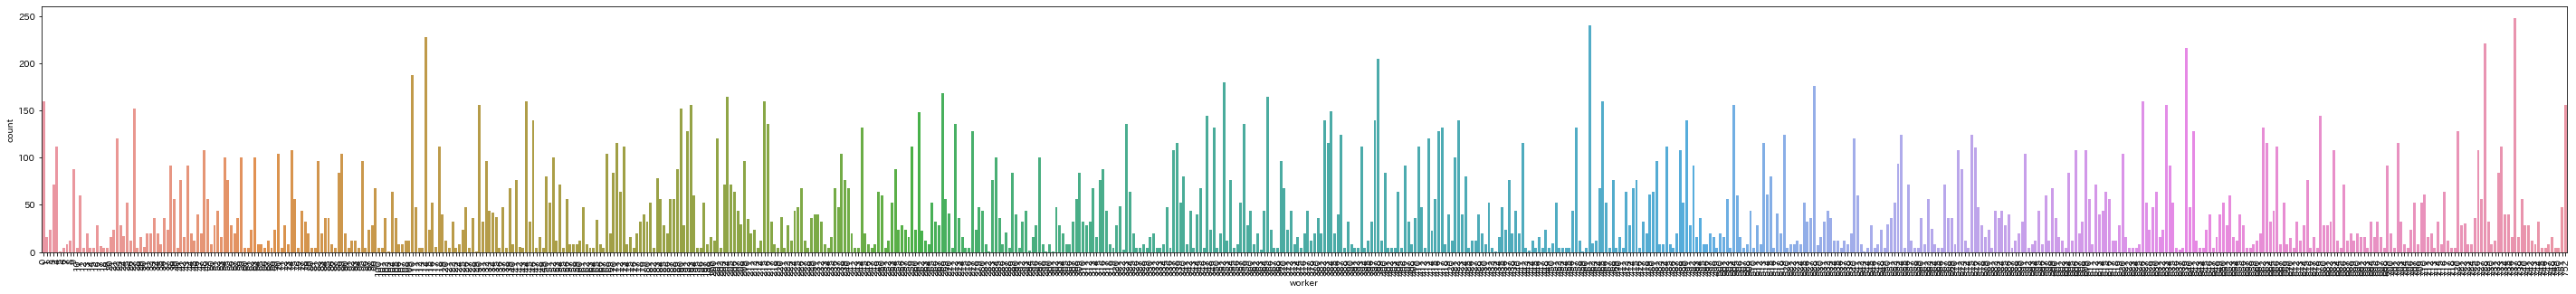

In [10]:
plt.figure(figsize=(50, 5))
sns.countplot(x="worker", data=df)
plt.xticks(rotation=90)
plt.show()

## Create Folds

In [11]:
skf = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)

for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["worker"])):
    df.loc[val_idx, "kfold"] = int(fold)

df["kfold"] = df["kfold"].astype(int)
df.head()

,worker,less_toxic,more_toxic,kfold
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,3
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...,0
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu...",4
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...,4
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist",1


## Create Test Data

In [12]:
test_df = pd.DataFrame()

for fold in range(config.n_fold):

    less_text = df[df["kfold"]==fold]["less_toxic"].values
    more_text = df[df["kfold"]==fold]["more_toxic"].values
    _test_df = pd.DataFrame()
    _test_df["text"] = np.concatenate((less_text, more_text), axis=0)
    _test_df["target"] = [0 for i in range(len(less_text))] + [1 for i in range(len(more_text))]
    _test_df["kfold"] = fold
    test_df = pd.concat([test_df, _test_df], axis=0).reset_index(drop=True)


display(test_df.head())

,text,target,kfold
0,"""And yes, people should recognize that but the...",0,0
1,"""\n\nHey Dude\nWell, I guess you know that TRE...",0,0
2,"""\n\n Sorry, I cant AFD the article while it i...",0,0
3,(1) It is a pity that you term well-sourced an...,0,0
4,"""\n\nIt is not false! I've showed you every po...",0,0


# Pytorch Dataset

In [13]:
class JigsawDataset:

    def __init__(self, df, tokenizer, max_length, is_train):

        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.is_train = is_train
        if self.is_train:    
            self.more_toxic = df["more_toxic"].values
            self.less_toxic = df["less_toxic"].values

        else:
            self.text = df["text"].values
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        if self.is_train:
                
            more_toxic = self.more_toxic[index]
            less_toxic = self.less_toxic[index]

            inputs_more_toxic = self.tokenizer.encode_plus(
                more_toxic,
                truncation=True,
                add_special_tokens=True,
                max_length = self.max_len,
                padding="max_length"
            )

            inputs_less_toxic = self.tokenizer.encode_plus(
                less_toxic,
                truncation=True,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length'
            )

            target = 1

            more_toxic_ids = inputs_more_toxic["input_ids"]
            more_toxic_mask = inputs_more_toxic["attention_mask"]

            less_toxic_ids = inputs_less_toxic["input_ids"]
            less_toxic_mask = inputs_less_toxic["attention_mask"]

            return {
                'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
                'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
                'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
                'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
                'target': torch.tensor(target, dtype=torch.long)
            }

        else:
            text = self.text[index]
            inputs = self.tokenizer.encode_plus(
                text,
                truncation=True,
                add_special_tokens=True,
                max_length=self.max_len,
                padding="max_length"
            )

            ids = inputs["input_ids"]
            mask = inputs["attention_mask"]

            return {
                "ids": torch.tensor(ids, dtype=torch.long),
                "mask": torch.tensor(mask, dtype=torch.long)
            }

## DataModule

In [14]:
class JigsawDataModule(LightningDataModule):

    def __init__(self, train_df, valid_df, test_df, cfg):

        super().__init__()
        self._train_df = train_df
        self._valid_df = valid_df
        self._test_df = test_df
        self._cfg = cfg

    def train_dataloader(self):
        dataset = JigsawDataset(
            df=self._train_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            is_train=True
            )
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = JigsawDataset(
            df=self._valid_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            is_train=True
            )
        return DataLoader(dataset, **self._cfg.valid_loader)

    def test_dataloader(self):
        dataset = JigsawDataset(
            df=self._test_df,
            tokenizer = self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            is_train=False
        )

        return DataLoader(dataset, **self._cfg.test_loader)

## Data Check

In [15]:
seed_everything(config.seed)

sample_dataloader = JigsawDataModule(df, df, test_df, config).train_dataloader()
for data in sample_dataloader:
    break

In [16]:
data["more_toxic_ids"].size()
data["more_toxic_mask"].size()
data["less_toxic_ids"].size()
data["less_toxic_mask"].size()

torch.Size([32, 128])

In [17]:
seed_everything(config.seed)

sample_dataloader = JigsawDataModule(df, df, test_df, config).test_dataloader()
for data in sample_dataloader:
    break

In [18]:
data["ids"].size()
data["mask"].size()

torch.Size([32, 128])

## Loss Function

In [19]:
def criterion(outputs1, outputs2, targets):
    return nn.MarginRankingLoss(margin=config.margin)(outputs1, outputs2, targets)

In [20]:
pretrain_model = AutoModel.from_pretrained(
    config.backbone.name,
    output_attentions=True
)
outputs = pretrain_model(data["ids"], data["mask"], output_hidden_states=True)
outputs.last_hidden_state.size(), outputs.attentions[-1].size()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(torch.Size([32, 128, 768]), torch.Size([32, 12, 128, 128]))

In [33]:
outputs.attentions[-1].size()

torch.Size([32, 12, 128, 128])

## Lightning Module

In [22]:
class JigsawModel(pl.LightningModule):

    def __init__(self, cfg, fold_num):

        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self.criterion = criterion
        self.save_hyperparameters(cfg)
        self.fold_num = fold_num

    def __build_model(self):

        self.base_model = AutoModel.from_pretrained(
            self.cfg.backbone.name,
            output_attentions=True
        )
        print(f"Use Model: {self.cfg.backbone.name}")

        self.norm = nn.LayerNorm(768)
        self.drop = nn.Dropout(p=0.3)
        self.head = nn.Sequential(nn.Linear(768, 256),
                                  nn.LeakyReLU(negative_slope=0.01),
                                  nn.Dropout(0.2),
                                  nn.Linear(256, 1))

    def forward(self, ids, mask):

        x = self.base_model(input_ids=ids, 
                              attention_mask=mask,
                              output_hidden_states=False)
        x = self.norm(torch.mean(x.last_hidden_state, dim=1))
        x = self.drop(x)
        x = self.head(x)

        return x

    def training_step(self, batch, batch_idx):

        more_toxic_ids = batch['more_toxic_ids']
        more_toxic_mask = batch['more_toxic_mask']
        less_toxic_ids = batch['less_toxic_ids']
        less_toxic_mask = batch['less_toxic_mask']
        targets = batch['target']

        more_toxic_outputs = self.forward(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = self.forward(less_toxic_ids, less_toxic_mask)

        loss = self.criterion(more_toxic_outputs, less_toxic_outputs, targets)

        return {"loss":loss, "targets":targets}

    def training_epoch_end(self, training_step_outputs):

        loss_list = []
        target_list = []

        for out in training_step_outputs:

            loss_list.extend([out["loss"].cpu().detach().tolist()])
            target_list.extend(out["targets"])

        meanloss = sum(loss_list)/len(loss_list)

        logs = {f"train_loss/fold{self.fold_num+1}": meanloss,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )

    def validation_step(self, batch, batch_idx):

        more_toxic_ids = batch['more_toxic_ids']
        more_toxic_mask = batch['more_toxic_mask']
        less_toxic_ids = batch['less_toxic_ids']
        less_toxic_mask = batch['less_toxic_mask']
        targets = batch['target']

        more_toxic_outputs = self.forward(more_toxic_ids, more_toxic_mask)
        less_toxic_outputs = self.forward(less_toxic_ids, less_toxic_mask)
        pred = more_toxic_outputs - less_toxic_outputs

        loss = self.criterion(more_toxic_outputs, less_toxic_outputs, targets)

        return {"loss":loss, "pred":pred, "targets":targets}

    def validation_epoch_end(self, validation_step_outputs):

        loss_list = []
        pred_list = []
        target_list = []

        for out in validation_step_outputs:
            loss_list.extend([out["loss"].cpu().detach().tolist()])
            pred_list.append(out["pred"].cpu().detach().numpy())
            target_list.extend(out["targets"])

        meanloss = sum(loss_list)/len(loss_list)
        pred_list = np.concatenate(pred_list)
        print(pred_list.shape)
        
        plt.plot(pred_list)
        plt.show()
        
        acc = np.sum(pred_list > 0)/len(pred_list)

        logs = {
            f"valid_loss/fold{self.fold_num+1}":meanloss,
            f"valid_acc/fold{self.fold_num+1}":acc,
        }

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )

    def test_step(self, batch, batch_idx):

        text_ids = batch['ids']
        text_mask = batch['mask']

        pred = self.forward(text_ids, text_mask)
        return {"pred":pred,}

    def test_epoch_end(self, test_step_outputs):

        pred_list = []

        for out in test_step_outputs:
            pred_list.extend([out["pred"].cpu().detach().numpy()])

        logs = {f"pred":pred_list,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=False
        )

    def predict_step(self, batch, batch_idx: int , dataloader_idx: int= None):

        text_ids = batch['ids']
        text_mask = batch['mask']
        pred = self.forward(text_ids, text_mask)
        return self(pred)

    def configure_optimizers(self):

        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )

        self.scheduler = eval(self.cfg.scheduler.name)(
            optimizer, **self.cfg.scheduler.params
        )
        
        scheduler = {"scheduler": self.scheduler, "interval": "step",}

        return [optimizer], [scheduler]

Error in callback <function _WandbInit._resume_backend at 0x7f582c3fc680> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Error in callback <function _WandbInit._pause_backend at 0x7f582c0f8c20> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [21]:
for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    df_test = test_df[test_df["kfold"]==fold].reset_index(drop=True)
    
    datamodule = JigsawDataModule(df_train, df_valid, df_test, config)
    sample_dataloader = JigsawDataModule(df_train, df_valid, df_test, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_loss_fold{fold+1}",
        monitor=f"valid_loss/fold{fold+1}",
        save_top_k=1,
        mode="min",
        save_last=False,
        dirpath=MODEL_DIR,
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['RoBERTa-Base', "MarginLoss"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
        deterministic=True,
        logger=[wandb_logger],
        **config.trainer
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W Context.cpp:69] Warning: torch.set_deterministic is in beta, and its design and  functionality may change in the future. (function operator())
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(pro

Use Model: roberta-base


wandb: Currently logged in as: dataskywalker (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-01-19 06:00:36.892911: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
fatal: ambiguous argument 'HEAD': unknown revision or path not in the working tree.
Use '--' to separate paths from revisions, like this:
'git <command> [<revision>...] -- [<file>...]'

CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ RobertaModel │  124 M │
│ 1 │ norm       │ LayerNorm    │  1.5 K │
│ 2 │ drop       │ Dropout      │      0 │
│ 3 │ head       │ Sequential   │  197 K │
└───┴────────────┴──────────────┴────────┘

Trainable params: 124 M                                                                      
Non-trainable params: 0                                                                      
Total params: 124 M                                                                          
Total estimated model params size (MB): 499

Output()

Epoch 0    ╸━━━━━━━━━━━━━━━━━━━━━━ 28/847 0:00:11 • 0:05:26 2.52it/s loss: 0.428 v_num: 0b2e 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_13960/2912380682.py", line 13, in <module>
    model = JigsawModel(config, fold)
  File "/tmp/ipykernel_13960/1886643718.py", line 7, in __init__
    self.__build_model()
  File "/tmp/ipykernel_13960/1886643718.py", line 16, in __build_model
    output_attentions=True
  File "/opt/conda/lib/python3.7/site-packages/transformers/models/auto/auto_factory.py", line 390, in from_pretrained
    pretrained_model_name_or_path, return_unused_kwargs=True, **kwargs
  File "/opt/conda/lib/python3.7/site-packages/transformers/models/auto/configuration_auto.py", line 446, in from_pretrained
    config_dict, _ = PretrainedConfig.get_config_dict(pretrained_model_name_or_path, **kwargs)
  File "/opt/conda/lib/python3.7/site-packag

TypeError: object of type 'NoneType' has no len()